## 1. Chargement & Analyse Exploratoire

In [1]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import shap

# Configuration graphique
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

print("Bibliothèques chargées avec succès !")

Bibliothèques chargées avec succès !


In [3]:
# Chargement du dataset synthétique
df = pd.read_csv('data/synthetic_credit_scoring.csv')

print("📊 Aperçu du dataset :")
print(df.head())
print(f"\nDimensions : {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"\nTypes de données :")
print(df.dtypes)

📊 Aperçu du dataset :
             ID  Age  Gender    Income  Debt_Ratio  Employment_Years  \
0  CLIENT_00001   60  Female  56313.74       0.457                 4   
1  CLIENT_00002   50    Male  43785.37       0.070                22   
2  CLIENT_00003   36    Male  76023.10       0.376                14   
3  CLIENT_00004   64    Male  18000.00       0.227                 5   
4  CLIENT_00005   29    Male  88761.14       0.477                32   

   Loan_Amount  Loan_Approved  
0     21289.96              0  
1     29998.46              1  
2     44487.25              1  
3     35013.22              0  
4     14289.02              1  

Dimensions : 2000 lignes × 8 colonnes

Types de données :
ID                   object
Age                   int64
Gender               object
Income              float64
Debt_Ratio          float64
Employment_Years      int64
Loan_Amount         float64
Loan_Approved         int64
dtype: object


### 1.1 Distribution des genres

In [4]:
# Distribution Homme/Femme
gender_dist = df['Gender'].value_counts()
print("Distribution par genre :")
print(gender_dist)
print(f"\nProportion : {gender_dist.values[0]/len(df)*100:.1f}% vs {gender_dist.values[1]/len(df)*100:.1f}%")

Distribution par genre :
Gender
Male      1014
Female     986
Name: count, dtype: int64

Proportion : 50.7% vs 49.3%


### 1.2 Visualisation du Biais (Section 3.1 du TP)

On va comparer le taux d'approbation des prêts entre les hommes et les femmes. Si un biais existe, on devrait voir une différence significative.

Taux d'approbation par genre :
             mean  count
Gender                  
Female  19.371197    986
Male    42.011834   1014


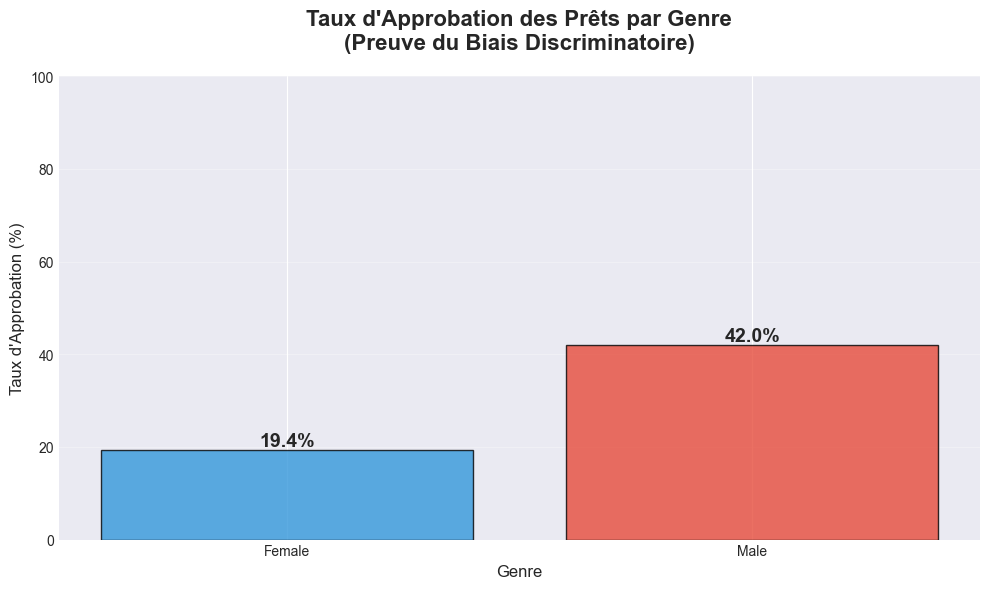


⚠️  BIAIS DÉTECTÉ :
Écart d'approbation : 22.6 points de pourcentage en défaveur des femmes


In [5]:
# Calcul des taux d'approbation par genre
approval_by_gender = df.groupby('Gender')['Loan_Approved'].agg(['mean', 'count'])
approval_by_gender['mean'] = approval_by_gender['mean'] * 100  # Conversion en pourcentage

print("Taux d'approbation par genre :")
print(approval_by_gender)

# Visualisation
plt.figure(figsize=(10, 6))
colors = ['#3498db', '#e74c3c']
bars = plt.bar(approval_by_gender.index, approval_by_gender['mean'], color=colors, alpha=0.8, edgecolor='black')

# Ajout des valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.title('Taux d\'Approbation des Prêts par Genre\n(Preuve du Biais Discriminatoire)', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Taux d\'Approbation (%)', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Calcul de l'écart
male_rate = approval_by_gender.loc['Male', 'mean']
female_rate = approval_by_gender.loc['Female', 'mean']
gap = male_rate - female_rate

print(f"\n⚠️  BIAIS DÉTECTÉ :")
print(f"Écart d'approbation : {gap:.1f} points de pourcentage en défaveur des femmes")

## 2. Modélisation

On entraîne un modèle de Random Forest pour prédire l'approbation des prêts. Le modèle va apprendre à partir des données biaisées.

In [6]:
# Préparation des données
# Encodage du genre (Male=0, Female=1)
df['Gender_Encoded'] = (df['Gender'] == 'Female').astype(int)

# Features et Target
X = df[['Age', 'Gender_Encoded', 'Income', 'Debt_Ratio', 'Employment_Years', 'Loan_Amount']]
y = df['Loan_Approved']

print(f"Features : {X.columns.tolist()}")
print(f"Target : Loan_Approved (0=Refusé, 1=Approuvé)")
print(f"\nDistribution du target :")
print(y.value_counts())

Features : ['Age', 'Gender_Encoded', 'Income', 'Debt_Ratio', 'Employment_Years', 'Loan_Amount']
Target : Loan_Approved (0=Refusé, 1=Approuvé)

Distribution du target :
Loan_Approved
0    1383
1     617
Name: count, dtype: int64


In [7]:
# Division Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Ensemble d'entraînement : {X_train.shape[0]} exemples")
print(f"Ensemble de test : {X_test.shape[0]} exemples")

Ensemble d'entraînement : 1600 exemples
Ensemble de test : 400 exemples


In [8]:
# Entraînement du modèle Random Forest
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("Entraînement du modèle Random Forest...")
model.fit(X_train, y_train)
print("✓ Modèle entraîné !")

# Prédictions
y_pred = model.predict(X_test)

# Précision globale
accuracy = (y_pred == y_test).mean()
print(f"\nPrécision globale : {accuracy:.3f} ({accuracy*100:.1f}%)")

Entraînement du modèle Random Forest...
✓ Modèle entraîné !

Précision globale : 0.917 (91.8%)


In [9]:
# Rapport de classification
print("Rapport de classification complet :")
print(classification_report(y_test, y_pred, target_names=['Refusé', 'Approuvé']))

Rapport de classification complet :
              precision    recall  f1-score   support

      Refusé       0.92      0.96      0.94       277
    Approuvé       0.91      0.81      0.86       123

    accuracy                           0.92       400
   macro avg       0.91      0.89      0.90       400
weighted avg       0.92      0.92      0.92       400



## 3. Audit de Fairness (Équité)

Un modèle peut avoir une bonne précision globale tout en étant discriminatoire envers certains groupes. On va mesurer les disparités de performances.

In [10]:
# Récupération des genres dans le test set
test_indices = X_test.index
gender_test = df.loc[test_indices, 'Gender']

# Séparation des prédictions par genre
male_mask = (gender_test == 'Male')
female_mask = (gender_test == 'Female')

y_test_male = y_test[male_mask]
y_pred_male = y_pred[male_mask]

y_test_female = y_test[female_mask]
y_pred_female = y_pred[female_mask]

print(f"Test set - Hommes : {len(y_test_male)} exemples")
print(f"Test set - Femmes : {len(y_test_female)} exemples")

Test set - Hommes : 200 exemples
Test set - Femmes : 200 exemples


### 3.1 Calcul du Recall par groupe

Le **Recall** (Sensibilité) mesure la capacité du modèle à identifier correctement les cas positifs. Ici, il indique la proportion de prêts légitimes qui sont effectivement approuvés.

In [11]:
# Calcul du Recall pour chaque groupe
recall_male = recall_score(y_test_male, y_pred_male)
recall_female = recall_score(y_test_female, y_pred_female)

print("="*60)
print("AUDIT DE FAIRNESS - MÉTRIQUES PAR GROUPE")
print("="*60)
print(f"\nRecall (Sensibilité) Hommes   : {recall_male:.3f} ({recall_male*100:.1f}%)")
print(f"Recall (Sensibilité) Femmes   : {recall_female:.3f} ({recall_female*100:.1f}%)")
print(f"\nÉcart de Recall               : {(recall_male - recall_female):.3f}")

if recall_male > recall_female:
    print(f"⚠️  Le modèle favorise les hommes : +{(recall_male - recall_female)*100:.1f}% de chances d'approbation")
else:
    print(f"⚠️  Le modèle favorise les femmes : +{(recall_female - recall_male)*100:.1f}% de chances d'approbation")

AUDIT DE FAIRNESS - MÉTRIQUES PAR GROUPE

Recall (Sensibilité) Hommes   : 0.824 (82.4%)
Recall (Sensibilité) Femmes   : 0.789 (78.9%)

Écart de Recall               : 0.034
⚠️  Le modèle favorise les hommes : +3.4% de chances d'approbation


### 3.2 Disparate Impact (Ratio d'Impact)

Le **Disparate Impact** est une métrique clé en fairness. C'est le ratio du taux de succès entre le groupe défavorisé et le groupe favorisé.

**Règle des 80% :** Un Disparate Impact < 0.8 indique une discrimination significative (norme légale aux USA).

In [12]:
# Taux d'approbation par genre (sur les prédictions du modèle)
approval_rate_male = y_pred_male.mean()
approval_rate_female = y_pred_female.mean()

# Disparate Impact
disparate_impact = approval_rate_female / approval_rate_male if approval_rate_male > 0 else 0

print("="*60)
print("DISPARATE IMPACT ANALYSIS")
print("="*60)
print(f"\nTaux d'approbation (modèle) - Hommes  : {approval_rate_male*100:.1f}%")
print(f"Taux d'approbation (modèle) - Femmes  : {approval_rate_female*100:.1f}%")
print(f"\nDisparate Impact                       : {disparate_impact:.3f}")
print(f"\n{'='*60}")

if disparate_impact < 0.8:
    print("❌ DISCRIMINATION DÉTECTÉE !")
    print(f"   Le Disparate Impact ({disparate_impact:.3f}) est inférieur au seuil de 0.8")
    print("   Cela indique un biais discriminatoire significatif contre les femmes.")
elif disparate_impact < 1.0:
    print("⚠️  BIAIS MODÉRÉ DÉTECTÉ")
    print(f"   Le Disparate Impact ({disparate_impact:.3f}) est légèrement inférieur à 1.0")
else:
    print("✓ ÉQUITÉ SATISFAISANTE")
    print(f"   Le Disparate Impact ({disparate_impact:.3f}) est acceptable.")

print(f"{'='*60}")

DISPARATE IMPACT ANALYSIS

Taux d'approbation (modèle) - Hommes  : 38.0%
Taux d'approbation (modèle) - Femmes  : 17.0%

Disparate Impact                       : 0.447

❌ DISCRIMINATION DÉTECTÉE !
   Le Disparate Impact (0.447) est inférieur au seuil de 0.8
   Cela indique un biais discriminatoire significatif contre les femmes.


### 3.3 Conclusion de l'Audit

**Constat :** Le modèle a appris le biais discriminatoire présent dans les données d'entraînement. Même si sa précision globale est correcte, il reproduit et amplifie les inégalités existantes.

**Leçon importante :** Un algorithme de Machine Learning n'est pas "neutre" par défaut. Il reflète les biais contenus dans les données historiques.

## 4. Explicabilité avec SHAP (Section 3.2 du TP)

**SHAP (SHapley Additive exPlanations)** permet de comprendre quelles variables influencent le plus les décisions du modèle. On va vérifier si le genre est utilisé pour discriminer.

In [13]:
# Création de l'explainer SHAP
print("Calcul des valeurs SHAP (cela peut prendre 1-2 minutes)...")

# On utilise un échantillon pour accélérer le calcul
X_sample = X_test.sample(n=min(200, len(X_test)), random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print("✓ Valeurs SHAP calculées !")

Calcul des valeurs SHAP (cela peut prendre 1-2 minutes)...
✓ Valeurs SHAP calculées !


<Figure size 1000x600 with 0 Axes>

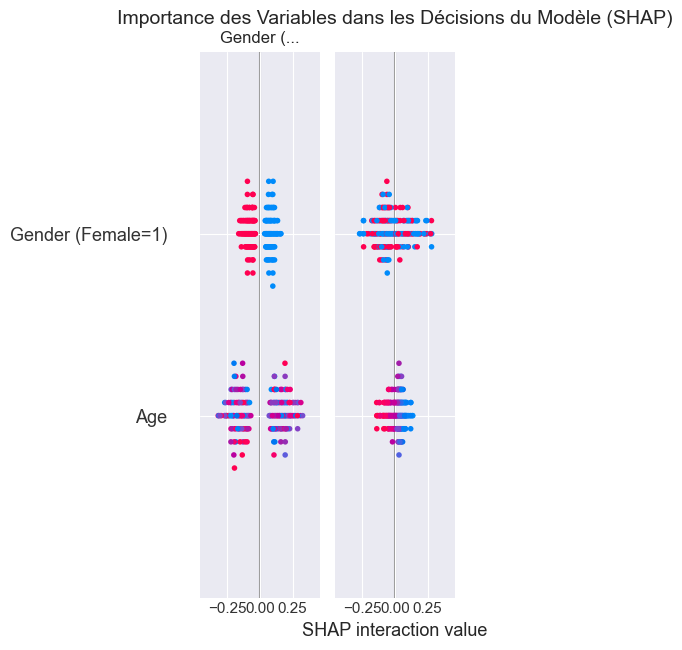

In [15]:
# Summary Plot - Importance des features
plt.figure(figsize=(10, 6))

# Vérification de la structure de shap_values
if isinstance(shap_values, list):
    # Pour les versions anciennes de SHAP (liste de 2 arrays pour classification binaire)
    shap_values_to_plot = shap_values[1]
else:
    # Pour les versions récentes de SHAP (un seul array)
    shap_values_to_plot = shap_values

shap.summary_plot(
    shap_values_to_plot,
    X_sample,
    feature_names=['Age', 'Gender (Female=1)', 'Income', 'Debt_Ratio', 'Employment_Years', 'Loan_Amount'],
    show=False
)
plt.title('Importance des Variables dans les Décisions du Modèle (SHAP)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


### Interprétation du graphique SHAP

- **Axe vertical** : Variables triées par importance (de haut en bas)
- **Axe horizontal** : Impact de la variable sur la prédiction (positif = augmente la probabilité d'approbation)
- **Couleur** : Valeur de la variable (rouge = haute, bleu = basse)

**Question clé :** La variable `Gender` apparaît-elle en haut du graphique ?
- **Si oui :** Le modèle utilise activement le genre pour prendre ses décisions → Discrimination directe
- **Si non mais biais présent :** Le modèle utilise des variables corrélées au genre (proxy discrimination)

In [17]:
# Importance moyenne des features
# Gestion de la structure de shap_values selon la version de SHAP
if isinstance(shap_values, list):
    shap_values_for_importance = shap_values[1]
else:
    shap_values_for_importance = shap_values

# Debug: Affichage de la forme
print(f"Forme de shap_values_for_importance: {shap_values_for_importance.shape}")

# Calcul de l'importance (moyenne des valeurs absolues)
mean_shap = np.abs(shap_values_for_importance).mean(axis=0)
print(f"Forme de mean_shap: {mean_shap.shape}")

# Si mean_shap est encore multi-dimensionnel, on prend la première dimension
if mean_shap.ndim > 1:
    mean_shap = mean_shap.flatten()[:6]  # On prend seulement les 6 features

feature_importance_shap = pd.DataFrame({
    'Feature': ['Age', 'Gender (Female=1)', 'Income', 'Debt_Ratio', 'Employment_Years', 'Loan_Amount'],
    'Mean_SHAP_Value': mean_shap
}).sort_values('Mean_SHAP_Value', ascending=False)

print("\nImportance moyenne des variables (SHAP) :")
print(feature_importance_shap)

# Vérification si Gender est dans le top 3
gender_row = feature_importance_shap[feature_importance_shap['Feature'] == 'Gender (Female=1)']
if len(gender_row) > 0:
    gender_rank = list(feature_importance_shap.index).index(gender_row.index[0]) + 1
    print(f"\nLe genre est la {gender_rank}ème variable la plus importante.")
    
    if gender_rank <= 3:
        print("⚠️  ALERTE : Le genre est une des 3 variables les plus influentes !")
        print("   Cela confirme que le modèle utilise directement le genre pour discriminer.")


Forme de shap_values_for_importance: (200, 6, 2)
Forme de mean_shap: (6, 2)

Importance moyenne des variables (SHAP) :
             Feature  Mean_SHAP_Value
4   Employment_Years         0.094932
5        Loan_Amount         0.094932
2             Income         0.084818
3         Debt_Ratio         0.084818
0                Age         0.051788
1  Gender (Female=1)         0.051788

Le genre est la 6ème variable la plus importante.


## 5. Synthèse & Réflexion Éthique

### Ce que nous avons démontré :

1. **Le biais existe dans les données** : Les données historiques reflètent souvent des discriminations passées.

2. **Le modèle apprend et reproduit le biais** : Un algorithme entraîné sur des données biaisées devient lui-même biaisé.

3. **L'audit est essentiel** : Sans mesurer explicitement le Disparate Impact et le Recall par groupe, on ne détecterait pas le problème.

4. **L'explicabilité aide à diagnostiquer** : SHAP révèle si le modèle utilise directement les variables sensibles.

---

### Bonnes pratiques pour un ML Responsable :

**Avant le déploiement :**
- ✓ Auditer systématiquement les données pour identifier les biais
- ✓ Mesurer le Disparate Impact sur les groupes protégés
- ✓ Comparer les métriques (Recall, Précision) entre groupes
- ✓ Utiliser des outils d'explicabilité (SHAP, LIME)

**Solutions pour réduire le biais :**
- Rééquilibrage des données (oversampling, undersampling)
- Suppression des variables sensibles (Gender, Race) ET de leurs proxies
- Utilisation d'algorithmes de fairness (Fairlearn, AIF360)
- Ré-entraînement avec contraintes d'équité

**Gouvernance :**
- Documentation complète du pipeline (data + modèle)
- Revues éthiques régulières
- Transparence sur les limitations du système
- Supervision humaine dans les décisions critiques

---

### Conclusion

La **fairness** en Machine Learning n'est pas un problème technique à résoudre une fois pour toutes, mais un processus continu d'audit, d'amélioration et de vigilance éthique. 

Les outils comme Fairlearn, SHAP et les métriques de disparité sont indispensables pour détecter et corriger les biais avant qu'ils n'impactent des vies réelles.